<a href="https://colab.research.google.com/github/dealtron/Proyek-Akhir-Dicoding/blob/master/Proyek_Pertama_Membuat_Model_NLP_dengan_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Pertama : Membuat Model NLP dengan TensorFlow

Nama : Aditya Ramadhan Moesya

Machine Learning - IBM

Disini saya akan mengerjakan tugas pertama saya di Dicoding pada sertifikasi "Belajar Pengembangan Machine Learning".

# Kriteria Submission
Berikut kriteria submission yang harus dipenuhi:

* Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel,

* Harus menggunakan LSTM dalam arsitektur model,

* Harus menggunakan model sequential,

* Validation set sebesar 20% dari total dataset,

* Harus menggunakan Embedding,

* Harus menggunakan fungsi tokenizer,

* Akurasi dari model minimal 75%.

# Code

## Installing Kaggle and Assigning Dataset

Disini saya akan menginstall kaggle terlebih dahulu untuk mengassign dataset yang akan saya pakai.

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityamoesya","key":"cb103a7262e69ccee9373fde2fe75bda"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

Disini saya menggunakan dataset dari Sentimental Analysis for Tweets dari kaggle. Yang dimana saya mempunyai tugas untuk menggunakan Sentimental Analysis terhadap tweet, untuk mengetahui seseorang yang membuat tweet tersebut mempunyai depresi atau tidak. Sehingga dapat dilakukan tindakan awal sebelum terjadi masalah yang lebih serius.

In [7]:
! kaggle datasets download -d gargmanas/sentimental-analysis-for-tweets

  0% 0.00/476k [00:00<?, ?B/s]
100% 476k/476k [00:00<00:00, 71.4MB/s]


In [8]:
!ls

kaggle.json  sample_data  sentimental-analysis-for-tweets.zip


In [9]:
!mkdir tweet
!unzip sentimental-analysis-for-tweets.zip -d tweet
!ls tweet

Archive:  sentimental-analysis-for-tweets.zip
  inflating: tweet/sentiment_tweets3.csv  
sentiment_tweets3.csv


## Importing Library

Disini saya akan mengimport library yang saya perlukan untuk melakukan proyek ini.

In [10]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## CSV to Dataframe

Disini saya akan mengassign default dataframe saya dengan nama df dengan dataset yang telah saya assign sebelumnya.

In [11]:
df = pd.read_csv('tweet/sentiment_tweets3.csv')
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


Disini saya akan mendrop kolom Index karena tidak diperlukan disini, dan mengubah nama kolom lainnya agar lebih simpel. Disini, Label (Depression Result) mempunyai 2 result, yaitu 0 yang berarti negatif (tidak depresi) dan 1 yang berarti positif (depresi).

In [12]:
df = df.drop(columns=['Index'])
df = df.rename({'message to examine': 'Tweet','label (depression result)' : 'Label'}, axis=1)
df.head()

,Tweet,Label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


Kemudian dicheck apakah terdapat data yang bersifat NULL atau tidak.

In [13]:
df.isnull().sum()

Tweet    0
Label    0
dtype: int64

Dan dilanjutkan dengan melihat shape dari dataset yang akan saya pakai.

In [14]:
df.shape

(10314, 2)

## Simple Data Visualization

Disini saya ingin melihat perbandingan dari banyaknya tweet yang berlabel 0 dan juga berlabel 1.

0    8000
1    2314
Name: Label, dtype: int64


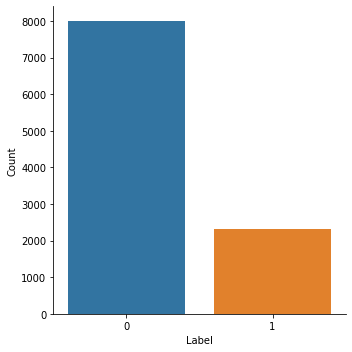

In [15]:
count = df['Label'].value_counts()
print(count)
sns.catplot(x='Label',kind="count", data=df)
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()

Dari sini kita bisa melihat, sebanyak :

*   8000 tweet yang berlabel 0 (tidak depresi),
*   2314 tweet yang berlabel 1 (depresi).

## Data Preprocessing

Disini saya akan melakukan data preprocessing. Ada beberapa tahapan untuk melakukan data preprocessing.

### *Lowercase*

Di tahapan ini, saya akan membuat seluruh huruf kapital menjadi huruf kecil semua.

In [16]:
df['Tweet_Lower'] = df['Tweet'].str.lower()
df.head()

,Tweet,Label,Tweet_Lower
0,just had a real good moment. i missssssssss hi...,0,just had a real good moment. i missssssssss hi...
1,is reading manga http://plurk.com/p/mzp1e,0,is reading manga http://plurk.com/p/mzp1e
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,@comeagainjen http://twitpic.com/2y2lx - http:...
3,@lapcat Need to send 'em to my accountant tomo...,0,@lapcat need to send 'em to my accountant tomo...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add me on myspace!!! myspace.com/lookthunder


### *Removing Special Characters*

Disini saya akan menghilangkan semua karakter yang bersifat simbol, angka, url, mention, hashtag, emoticon, spasi yang bersifat double, dan juga karakter 1 huruf.

In [17]:
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
df['Tweet_Rem'] = df['Tweet_Lower'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['Tweet_Rem'] = df['Tweet_Rem'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['Tweet_Rem'] = df['Tweet_Rem'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['Tweet_Rem'] = df['Tweet_Rem'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['Tweet_Rem'] = df['Tweet_Rem'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['Tweet_Rem'] = df['Tweet_Rem'].apply(remove_singl_char)
df.head()

,Tweet,Label,Tweet_Lower,Tweet_Rem
0,just had a real good moment. i missssssssss hi...,0,just had a real good moment. i missssssssss hi...,just had real good moment missssssssss him s...
1,is reading manga http://plurk.com/p/mzp1e,0,is reading manga http://plurk.com/p/mzp1e,is reading manga
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,@comeagainjen http://twitpic.com/2y2lx - http:...,
3,@lapcat Need to send 'em to my accountant tomo...,0,@lapcat need to send 'em to my accountant tomo...,need to send em to my accountant tomorrow oddl...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add me on myspace!!! myspace.com/lookthunder,add me on myspace myspacecomlookthunder


### *Removing Stopwords*

Disini saya akan melakukan proses penghilangan stopwords. Langkah pertama yang saya lakukan adalah melakukan tokenization per-kata.

In [18]:
def word_tokenize_wrapper(text):
    return word_tokenize(text)

df['Tweet_Token'] = df['Tweet_Rem'].apply(word_tokenize_wrapper)
df.head()

,Tweet,Label,Tweet_Lower,Tweet_Rem,Tweet_Token
0,just had a real good moment. i missssssssss hi...,0,just had a real good moment. i missssssssss hi...,just had real good moment missssssssss him s...,"[just, had, real, good, moment, missssssssss, ..."
1,is reading manga http://plurk.com/p/mzp1e,0,is reading manga http://plurk.com/p/mzp1e,is reading manga,"[is, reading, manga]"
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,@comeagainjen http://twitpic.com/2y2lx - http:...,,[]
3,@lapcat Need to send 'em to my accountant tomo...,0,@lapcat need to send 'em to my accountant tomo...,need to send em to my accountant tomorrow oddl...,"[need, to, send, em, to, my, accountant, tomor..."
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add me on myspace!!! myspace.com/lookthunder,add me on myspace myspacecomlookthunder,"[add, me, on, myspace, myspacecomlookthunder]"


Kemudian saya melakukan stopwords removal terhadap kata yang telah ditokenisasi sebelumnya.

In [19]:
list_stopwords = stopwords.words('english')
list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['Tweet_Token_Stopwords'] = df['Tweet_Token'].apply(stopwords_removal)
df.head()

,Tweet,Label,Tweet_Lower,Tweet_Rem,Tweet_Token,Tweet_Token_Stopwords
0,just had a real good moment. i missssssssss hi...,0,just had a real good moment. i missssssssss hi...,just had real good moment missssssssss him s...,"[just, had, real, good, moment, missssssssss, ...","[real, good, moment, missssssssss, much]"
1,is reading manga http://plurk.com/p/mzp1e,0,is reading manga http://plurk.com/p/mzp1e,is reading manga,"[is, reading, manga]","[reading, manga]"
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,@comeagainjen http://twitpic.com/2y2lx - http:...,,[],[]
3,@lapcat Need to send 'em to my accountant tomo...,0,@lapcat need to send 'em to my accountant tomo...,need to send em to my accountant tomorrow oddl...,"[need, to, send, em, to, my, accountant, tomor...","[need, send, em, accountant, tomorrow, oddly, ..."
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add me on myspace!!! myspace.com/lookthunder,add me on myspace myspacecomlookthunder,"[add, me, on, myspace, myspacecomlookthunder]","[add, myspace, myspacecomlookthunder]"


### *To String (again)*

Dan ini adalah kumpulan proses yang saya lakukan untuk mendapatkan Tweet_String, yaitu tweet yang telah saya olah hingga tahap akhir yang akan digunakan untuk pemodelan.

In [20]:
df['Tweet_String'] = df['Tweet_Token_Stopwords'].apply(' '.join)
df = df[['Tweet','Tweet_Lower','Tweet_Rem','Tweet_Token','Tweet_Token_Stopwords','Tweet_String','Label']]
df.head()

,Tweet,Tweet_Lower,Tweet_Rem,Tweet_Token,Tweet_Token_Stopwords,Tweet_String,Label
0,just had a real good moment. i missssssssss hi...,just had a real good moment. i missssssssss hi...,just had real good moment missssssssss him s...,"[just, had, real, good, moment, missssssssss, ...","[real, good, moment, missssssssss, much]",real good moment missssssssss much,0
1,is reading manga http://plurk.com/p/mzp1e,is reading manga http://plurk.com/p/mzp1e,is reading manga,"[is, reading, manga]","[reading, manga]",reading manga,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,@comeagainjen http://twitpic.com/2y2lx - http:...,,[],[],,0
3,@lapcat Need to send 'em to my accountant tomo...,@lapcat need to send 'em to my accountant tomo...,need to send em to my accountant tomorrow oddl...,"[need, to, send, em, to, my, accountant, tomor...","[need, send, em, accountant, tomorrow, oddly, ...",need send em accountant tomorrow oddly wasnt e...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,add me on myspace!!! myspace.com/lookthunder,add me on myspace myspacecomlookthunder,"[add, me, on, myspace, myspacecomlookthunder]","[add, myspace, myspacecomlookthunder]",add myspace myspacecomlookthunder,0


### *Dropping some Table and Cells*

Disini saya akan mendrop table yang tidak akan saya pakai dan hanya menyisakan Tweet_String, yang akan saya gunakan untuk modelling nanti. Disini saya akan merubah nama Tweet_string menjadi Tweet.

In [21]:
df_ts = df.drop(columns=['Tweet','Tweet_Lower','Tweet_Rem','Tweet_Token','Tweet_Token_Stopwords'])
df_ts = df_ts.rename({'Tweet_String': 'Tweet'}, axis=1)
df_ts.head()

,Tweet,Label
0,real good moment missssssssss much,0
1,reading manga,0
2,,0
3,need send em accountant tomorrow oddly wasnt e...,0
4,add myspace myspacecomlookthunder,0


Dapat kita lihat di baris 2, terdapat cells yang tidak ada isinya sama sekali dan disini saya akan mendrop semua sel yang empty, agar tidak mengganggu pemodelan saya nanti.

In [22]:
df_ts.isnull().sum()

Tweet    0
Label    0
dtype: int64

Cells yang kosong ternyata tidak bersifat NULL, maka disini saya akan mengubah data yang empty menjadi Null terlebih dahulu, yang kemudian akan saya drop.

In [23]:
nan_value = float("NaN")
df_ts.replace("", nan_value, inplace=True)

In [24]:
df_ts.isnull().sum()

Tweet    44
Label     0
dtype: int64

In [25]:
df_nonull = df_ts.dropna()
df_nonull

,Tweet,Label
0,real good moment missssssssss much,0
1,reading manga,0
3,need send em accountant tomorrow oddly wasnt e...,0
4,add myspace myspacecomlookthunder,0
5,sleepy good times tonight though,0
...,...,...
10308,many sufferers depression arent sad feel nothi...,1
10309,depression herbo mood im done stressing people...,1
10310,depression succumbs brain makes feel like youl...,1
10311,ketamine nasal spray shows promise depression ...,1


### *Dummies Assigning*

In [26]:
category = pd.get_dummies(df_nonull.Label)
df_new = pd.concat([df_nonull, category], axis=1)
df_new = df_new.drop(columns='Label')
df_new.head()

,Tweet,0,1
0,real good moment missssssssss much,1,0
1,reading manga,1,0
3,need send em accountant tomorrow oddly wasnt e...,1,0
4,add myspace myspacecomlookthunder,1,0
5,sleepy good times tonight though,1,0


In [27]:
df_new = df_new.rename({0: 'Negative',1:'Positive'}, axis=1)
df_new

,Tweet,Negative,Positive
0,real good moment missssssssss much,1,0
1,reading manga,1,0
3,need send em accountant tomorrow oddly wasnt e...,1,0
4,add myspace myspacecomlookthunder,1,0
5,sleepy good times tonight though,1,0
...,...,...,...
10308,many sufferers depression arent sad feel nothi...,0,1
10309,depression herbo mood im done stressing people...,0,1
10310,depression succumbs brain makes feel like youl...,0,1
10311,ketamine nasal spray shows promise depression ...,0,1


## Modelling

Disini saya akan melakukan train test split dan mengatur model yang akan saya pakai untuk pemodelan. Disini saya menggunakan test_size sebesar 20%, sesuai dengan kriteria submission.

In [28]:
tweet = df_new['Tweet'].values
label = df_new[['Negative','Positive']].values

In [29]:
tweet_train, tweet_test, label_train, label_test = train_test_split(tweet, label, test_size=0.2)

In [30]:
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.fit_on_texts(tweet_train) 
tokenizer.fit_on_texts(tweet_test)
 
sekuens_train = tokenizer.texts_to_sequences(tweet_train)
sekuens_test = tokenizer.texts_to_sequences(tweet_test)
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=32),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')])

In [32]:
model.compile(
    optimizer = tf.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

Sesuai dengan review dari tugas saya sebelumnya, saya disarankan untuk menggunakan Callback untuk model saya. Berikut adalah callback yang saya gunakan.

In [33]:
class forCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      self.model.stop_training = True
      print("\n Great! The accuracy from training and validation set is already reach > 98%.")

Callback = forCallback()

In [35]:
history = model.fit(
    padded_train,
    label_train,
    validation_data = (padded_test, label_test),
    epochs = 10,
    verbose = 1,
    callbacks=[Callback])

Epoch 1/10
257/257 [==============================] - 19s 64ms/step - loss: 0.2078 - accuracy: 0.9208 - val_loss: 0.0683 - val_accuracy: 0.9781
Epoch 2/10
257/257 [==============================] - 16s 62ms/step - loss: 0.0266 - accuracy: 0.9933 - val_loss: 0.0779 - val_accuracy: 0.9800

 Great! The accuracy from training and validation set is already reach > 98%.


## Visualizing Model Accuracy

Berikut adalah visualisasi plot dari loss dan akurasi model yang saya pakai

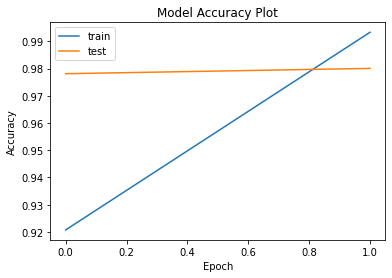

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

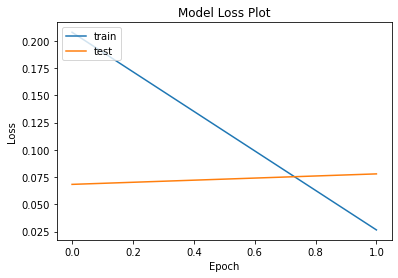

In [37]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()